# 1. Some assumptions

- one participant has always the same health status in the same exercise repetitions in one day 
- one participant has the same health status in different exercises in one day
- the performance of all participant in the same day is stabile

# 2. Naive attempt

just normalize each exercise respectively 

In [1]:
%reset -f

import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import preprocessing

def calc_force(df):
    df['force'] = df['Fx']**2 + df['Fy']**2 + df['Fz']**2
    df['force'] = df['force'].pow(1/2)
    return df

def calc_velocity(df):
    df['velocity'] = df['Lx']**2 + df['Ly']**2 + df['Lz']
    df['velocity'] = df['velocity'].pow(1/2)
    return df
    
def evaluation_method1(df, factor=2, reset_index=True):
    
    df['score'] = df['front']*df['velocity']/factor
    tmp = df[['day', 'exc_num', 'exc_times', 'score', 'uid']]
    tmp = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times' ]).sum()
    if reset_index:
        tmp = tmp.reset_index()
    return tmp

def calc_avg_force(df, reset_index=True):
    if 'force' not in df.columns:
        df = calc_force(df)
        
    tmp = df[['day', 'exc_num', 'exc_times', 'force', 'uid']]
    tmp = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()
    
    if reset_index:
        tmp = tmp.reset_index()
        
    return tmp
    
    
def calc_avg_velocity(df, reset_index=True):
    if 'velocity' not in df.columns:
        df = calc_velocity(df)
        
    tmp = df[['day', 'exc_num', 'exc_times', 'velocity', 'uid']]
    tmp = tmp.groupby(['uid', 'day', 'exc_num', 'exc_times']).mean()
    
    if reset_index:
        tmp = tmp.reset_index()
        
    return tmp

### 2.1 Load and transform dataset

load data 

In [2]:
all_data = pd.read_csv('../data/all_data1.csv')
all_data = calc_force(all_data)
all_data = calc_velocity(all_data)
score = evaluation_method1(all_data, reset_index=False)
avg_force = calc_avg_force(all_data, reset_index=False)
avg_velocity = calc_avg_velocity(all_data, reset_index=False)

df_length = pd.read_csv('../data/clean_data_length.csv')
df_score1 = pd.read_csv('../data/clean_data_score1.csv')

df_length = df_length.set_index(['uid', 'day', 'exc_num', 'exc_times'])
df_score1 = df_score1.set_index(['uid', 'day', 'exc_num', 'exc_times'])


cleaned_index = pd.concat([df_length, df_score1], axis=1)
cleaned_index.columns

Index(['length', 'global_length', 'user_mask_length', 'score', 'global_score1',
       'user_mask_score1'],
      dtype='object')

transform data 

In [3]:
cleaned_index = cleaned_index[(cleaned_index['global_length']>0) | (cleaned_index['user_mask_length']>0)]
cleaned_index = cleaned_index[(cleaned_index['global_score1']>0) & (cleaned_index['user_mask_score1']>0)]
# cleaned_index = cleaned_index[(cleaned_index['global_score1']>0)]
# cleaned_index = cleaned_index[(cleaned_index['user_mask_score1']>0)]

cleaned_index = cleaned_index.reset_index()
cleaned_index = cleaned_index.set_index(['uid', 'day', 'exc_num', 'exc_times'])
cleaned_index = cleaned_index['length']

# print(cleaned_index.head())
# print(score.head())
# print(avg_force.head())
# print(avg_velocity.head())

cleaned_data = pd.concat([cleaned_index, score, avg_force, avg_velocity], axis=1)
# print(cleaned_data.columns)
cleaned_data = cleaned_data.dropna()
cleaned_data = cleaned_data.reset_index()

# cleaned_data = cleaned_data[['uid', 'day', 'exc_num', 'exc_times', 'score', ]]
cleaned_data = cleaned_data.T.drop_duplicates().T
# cleaned_data = cleaned_data[['exc_num', 'length', 'score', 'force']]
cleaned_data.head()

,uid,day,exc_num,exc_times,length,score,force,velocity
0,1.0,1.0,1.1,2.0,2955.0,6.829834,23.072412,0.252595
1,1.0,1.0,1.2,1.0,3903.0,43.530778,37.559940,0.285011
2,1.0,1.0,1.2,3.0,3383.0,46.351238,30.321137,0.284888
3,1.0,1.0,1.2,4.0,3102.0,40.297263,37.960616,0.299663
4,1.0,1.0,1.2,5.0,2490.0,43.987007,40.989272,0.353186


normalize dataset 

In [4]:
cleaned_data = cleaned_data.set_index(['exc_num'])
grouped = cleaned_data.groupby(cleaned_data.index)
for index, group in grouped:
    X_train = group['score'].as_matrix().reshape(-1, 1)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    new_score = scaler.transform(X_train)
    cleaned_data.loc[index, 'new_score'] = new_score.T[0]
    
tmp = cleaned_data.reset_index()
tmp = cleaned_data[['uid', 'day', 'velocity', 'length', 'force', 'new_score']]
tmp.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


,uid,day,velocity,length,force,new_score
exc_num,,,,,,
1.1,1.0,1.0,0.252595,2955.0,23.072412,-0.888399
1.2,1.0,1.0,0.285011,3903.0,37.559940,-0.211528
1.2,1.0,1.0,0.284888,3383.0,30.321137,-0.038790
1.2,1.0,1.0,0.299663,3102.0,37.960616,-0.409564
1.2,1.0,1.0,0.353186,2490.0,40.989272,-0.183587


### 2.2 Corelation analysis

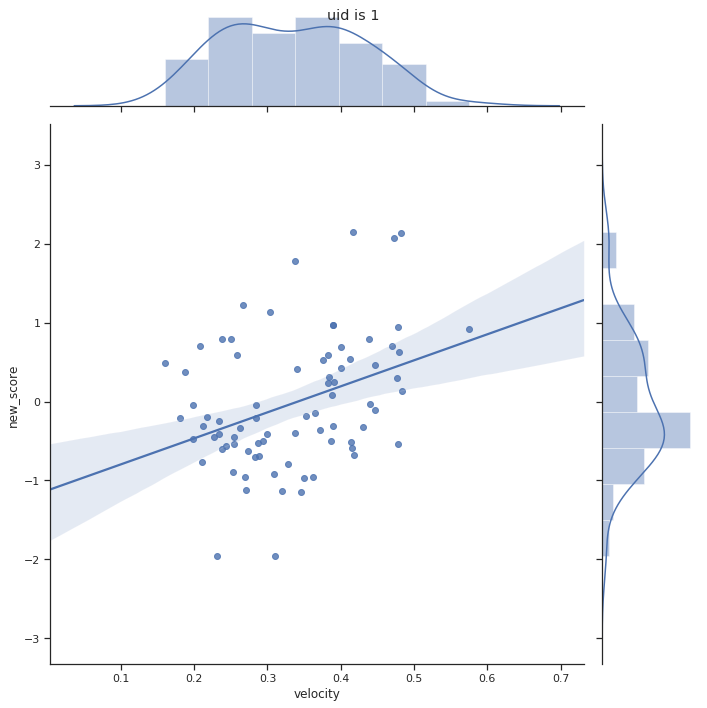

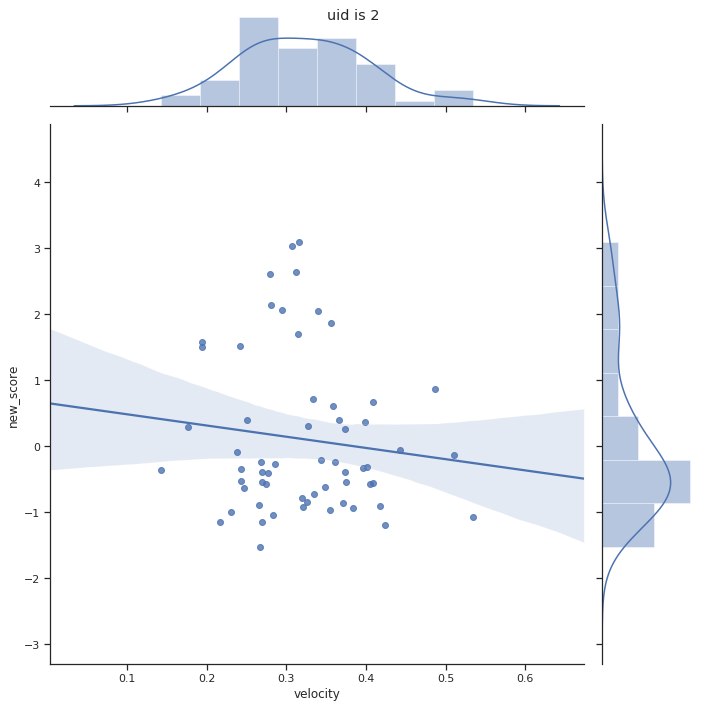

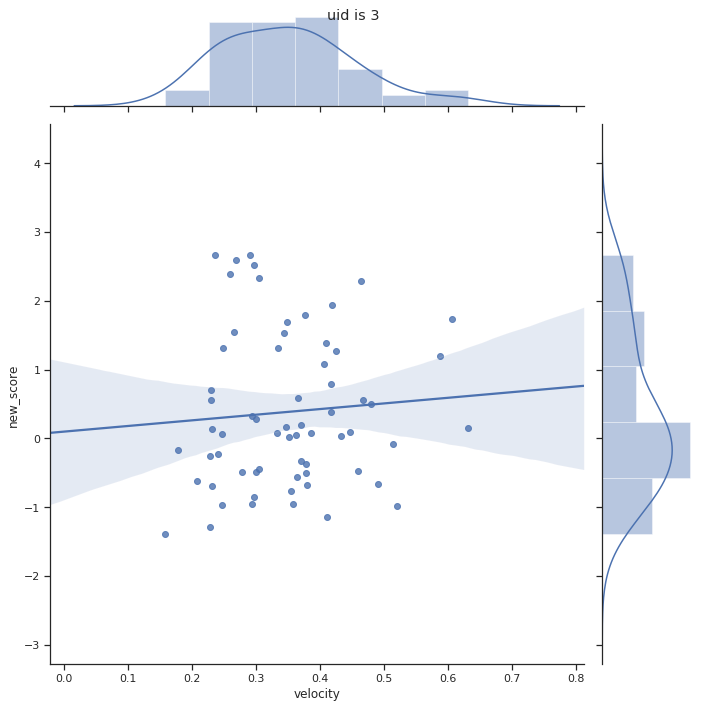

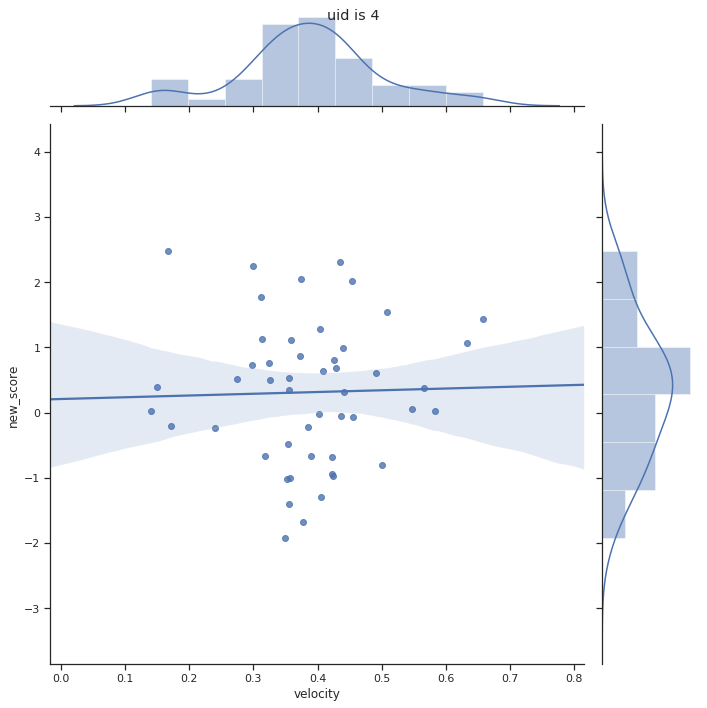

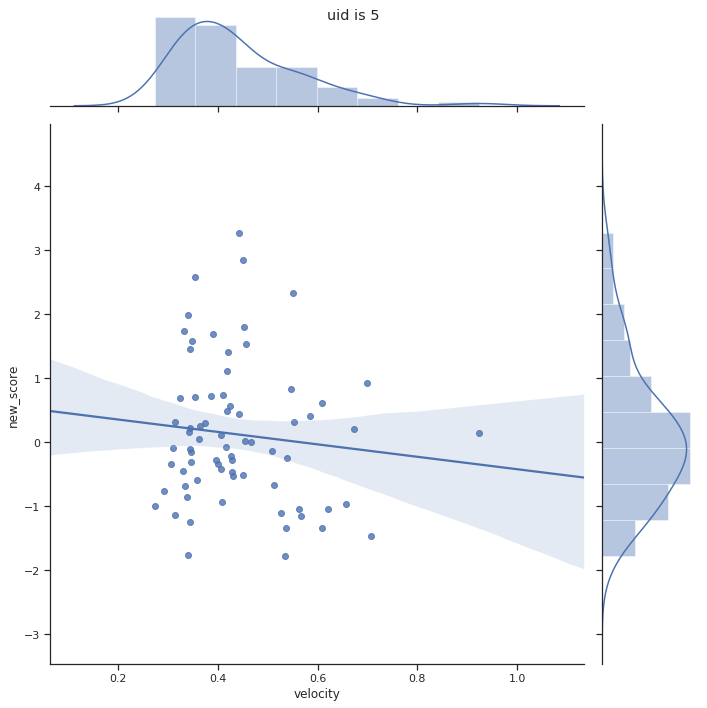

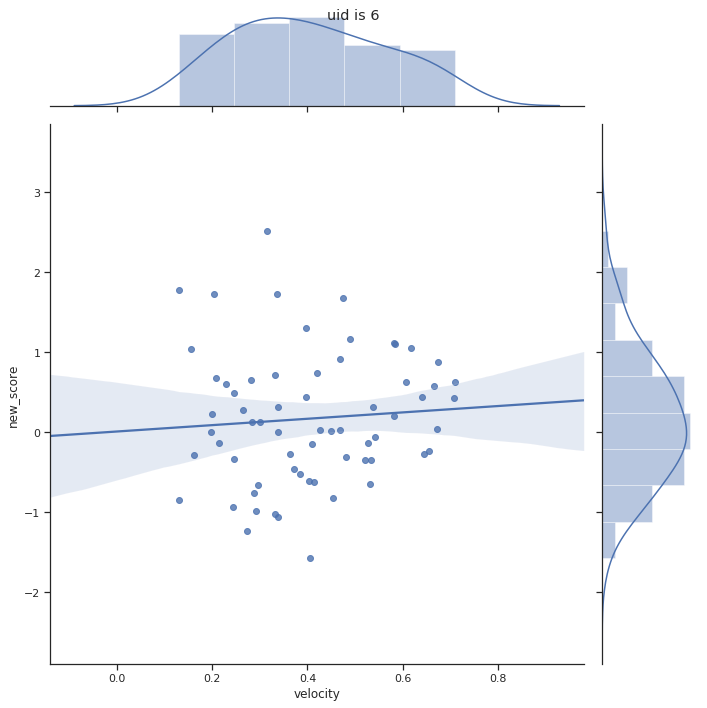

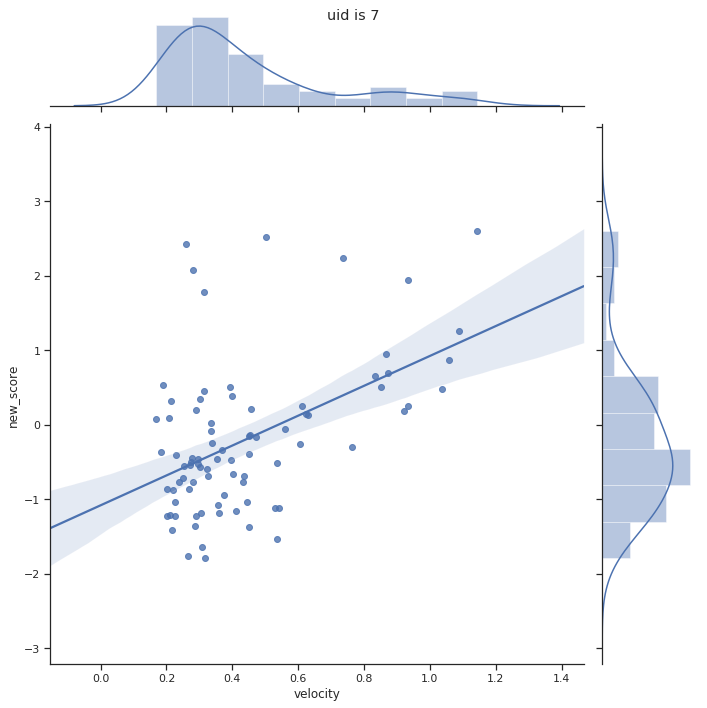

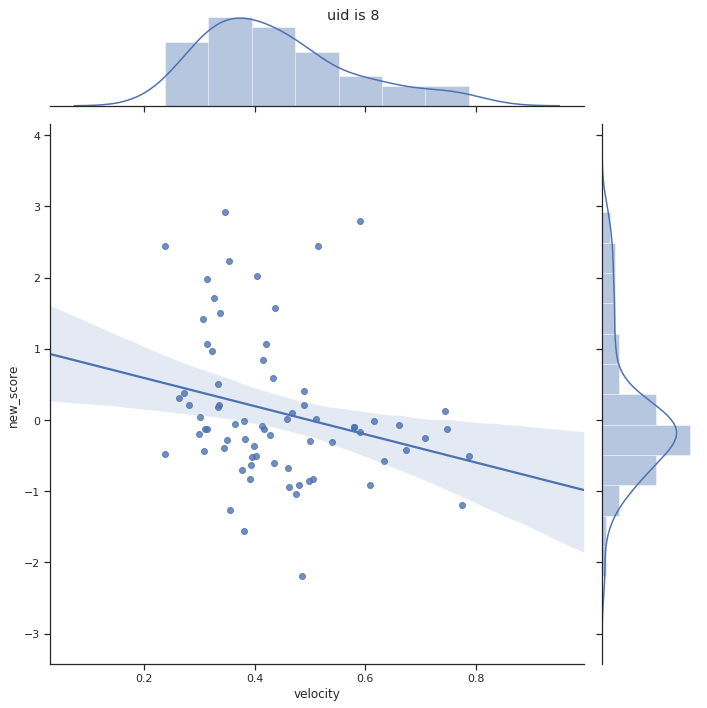

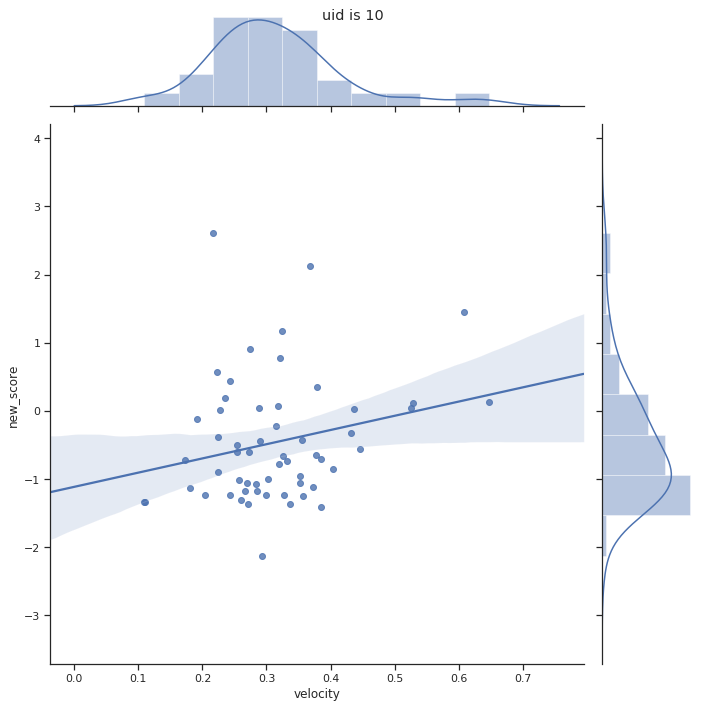

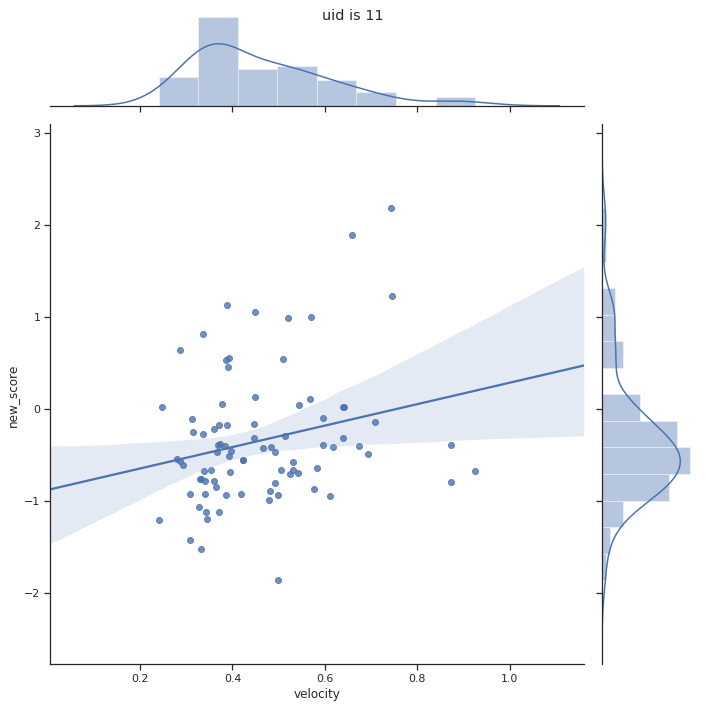

In [13]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="velocity", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

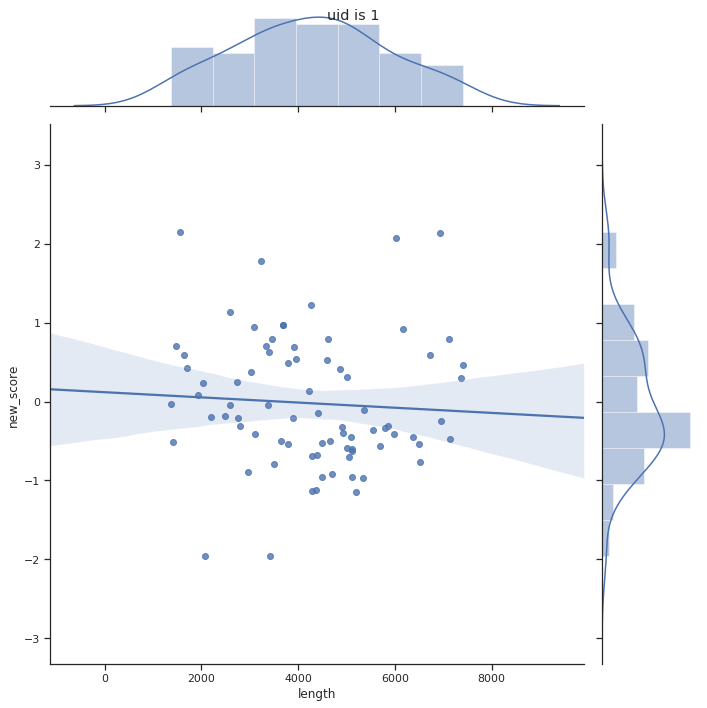

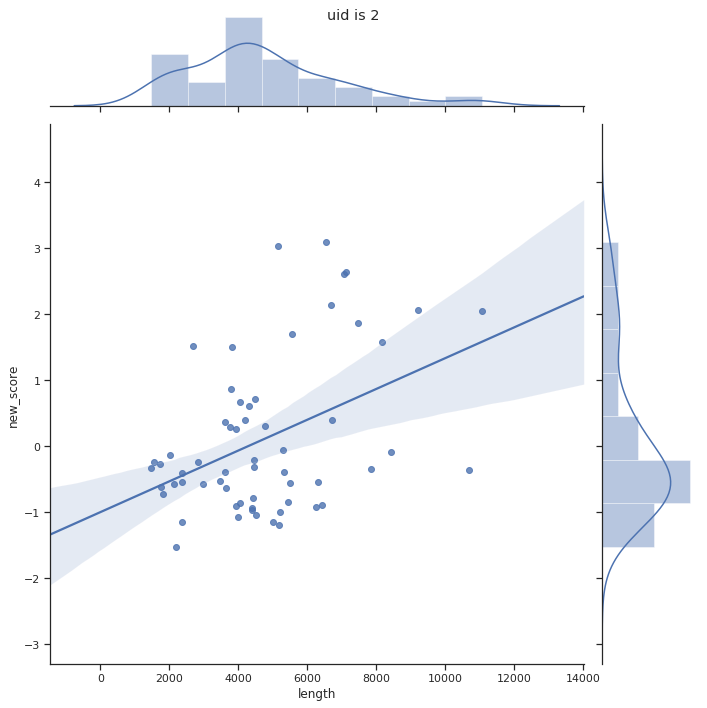

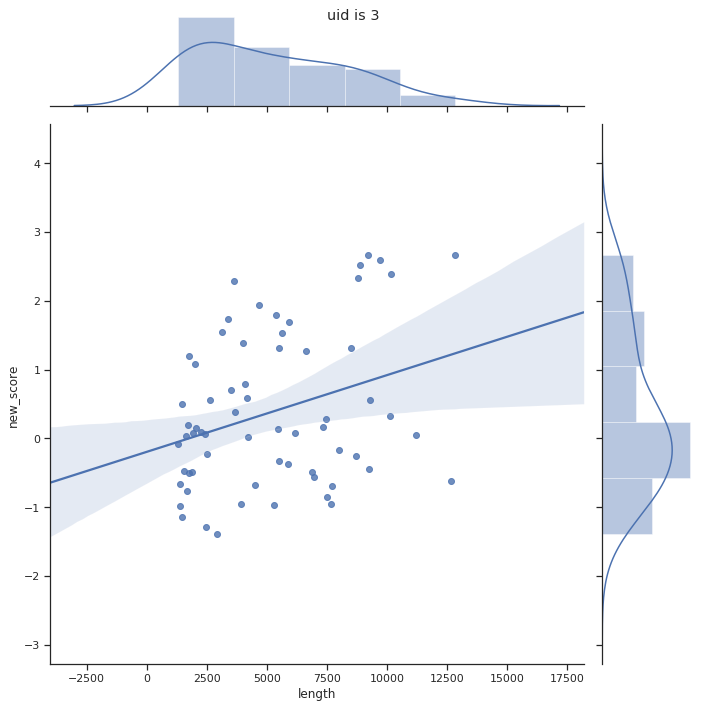

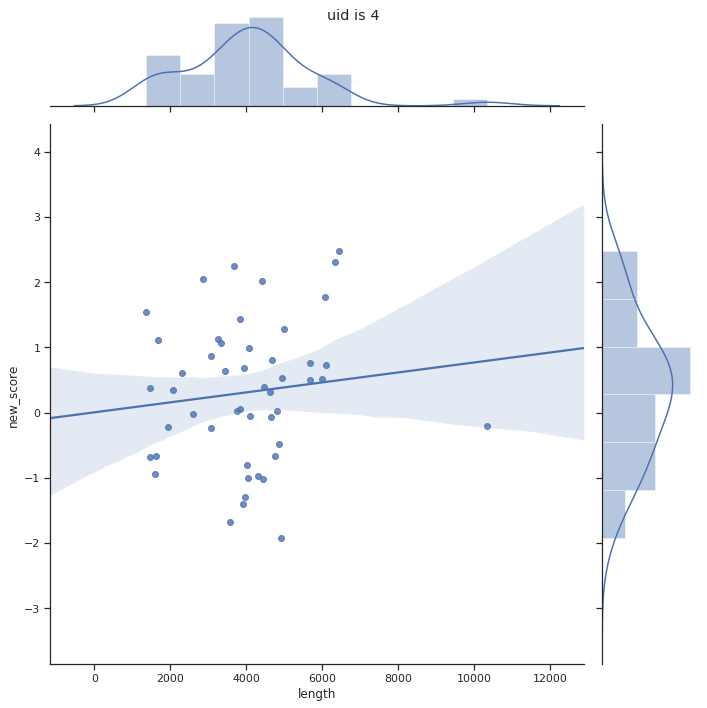

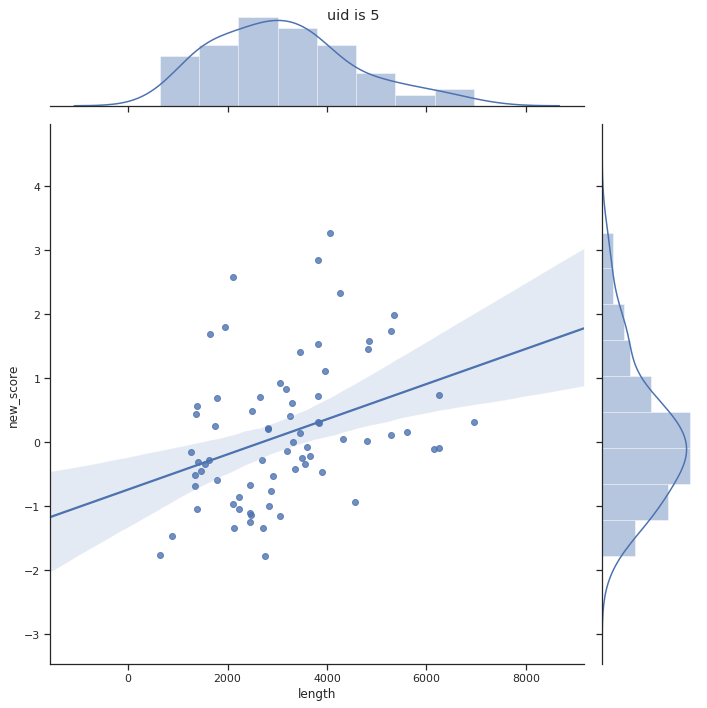

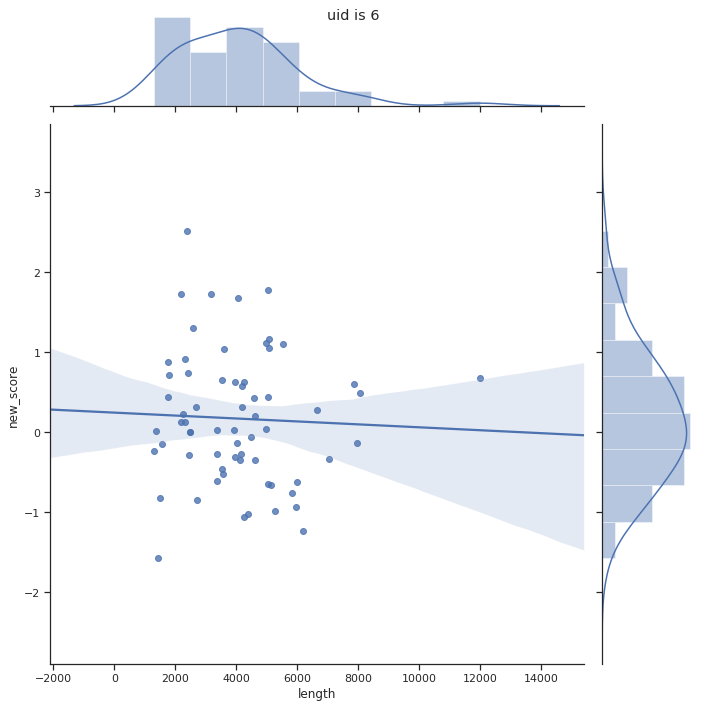

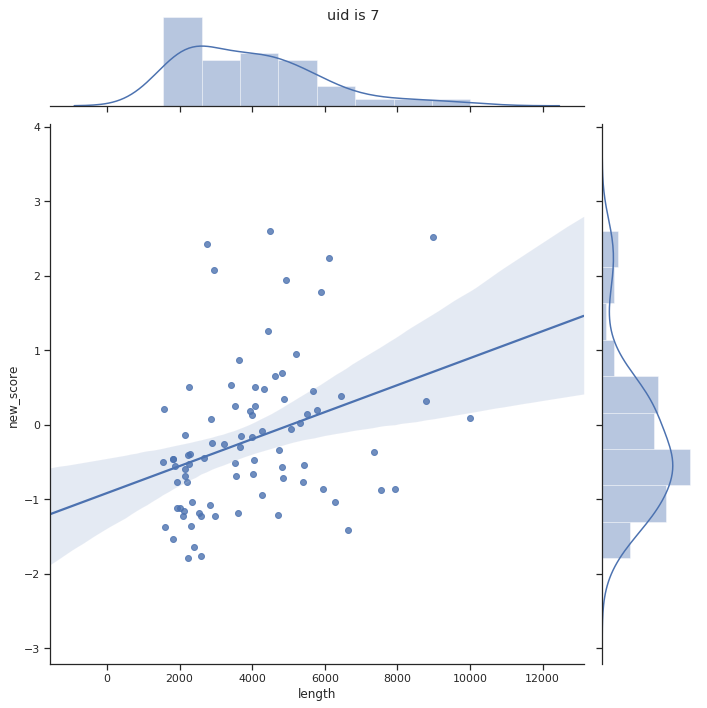

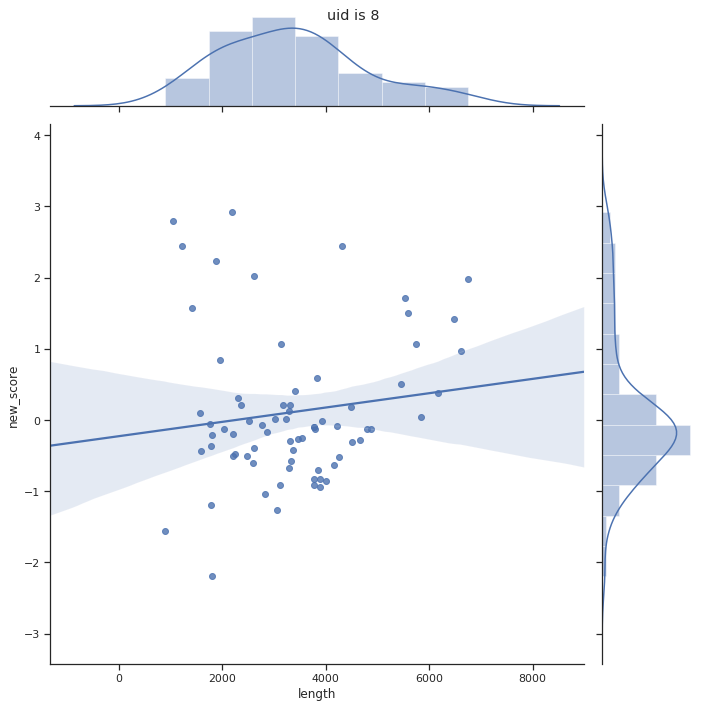

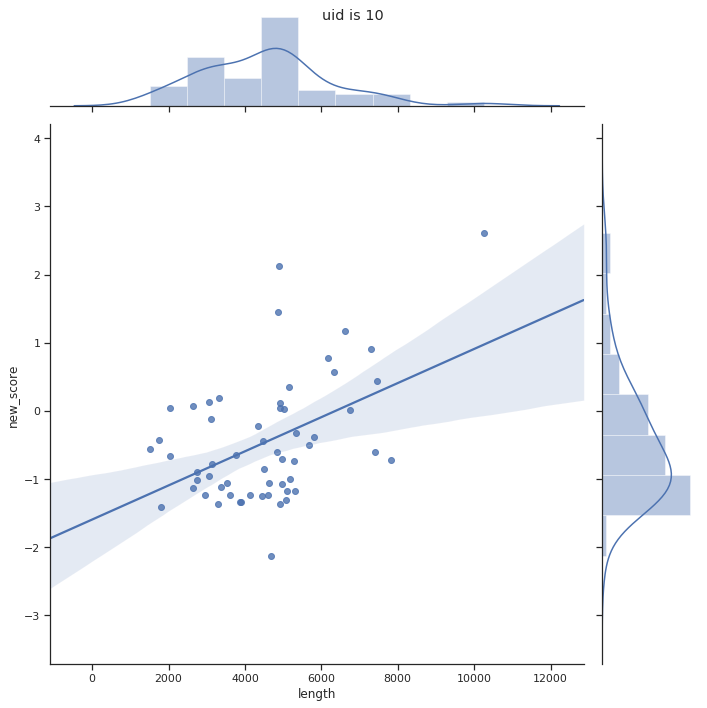

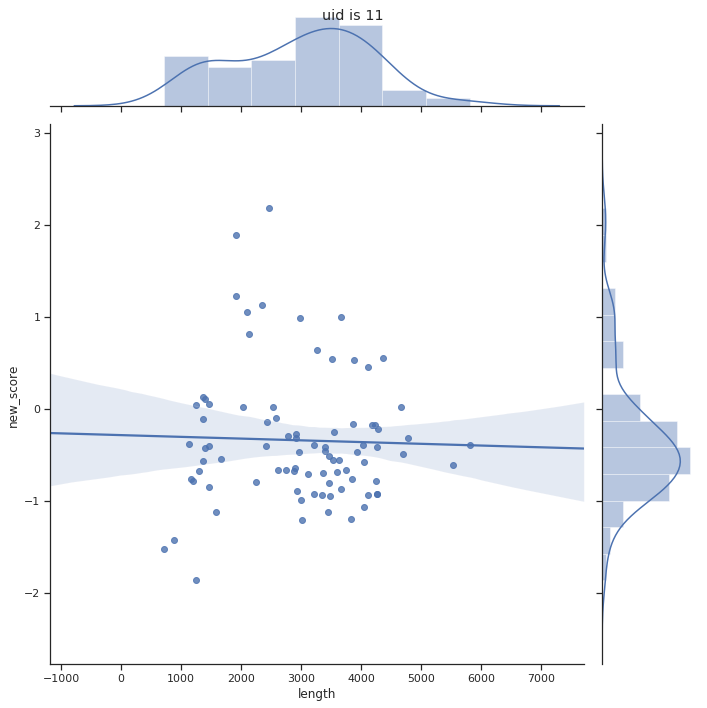

In [11]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="length", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

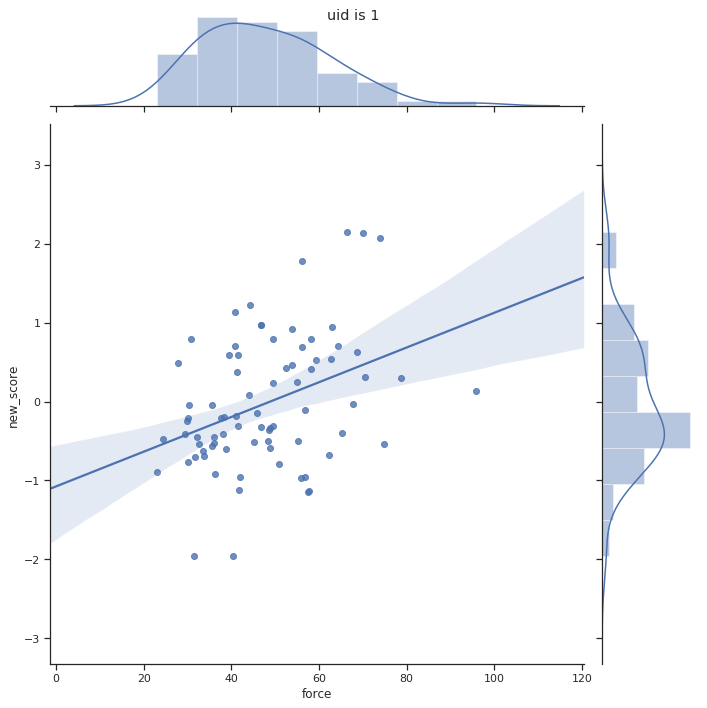

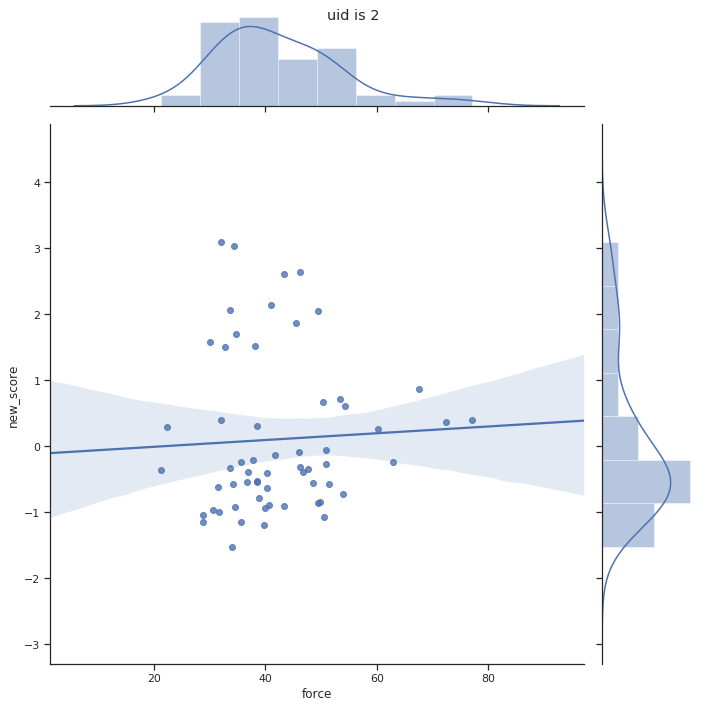

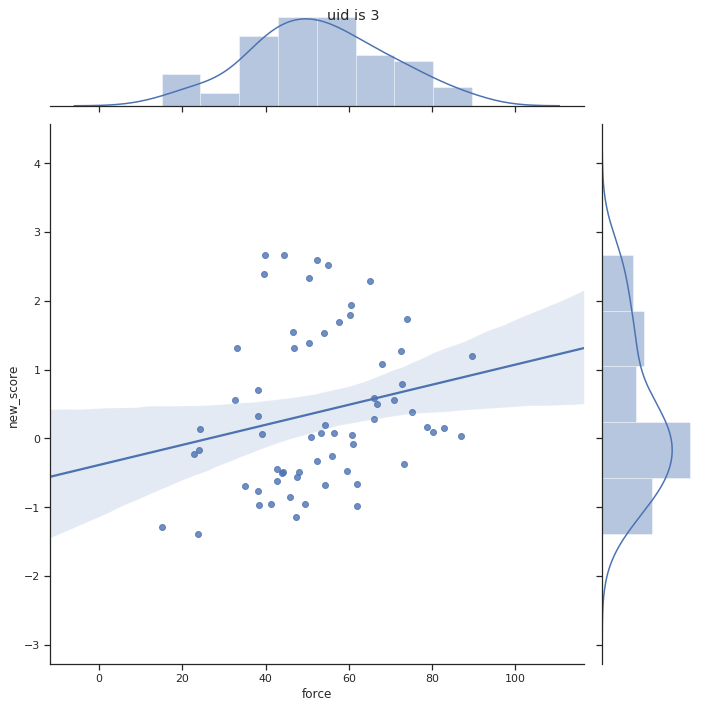

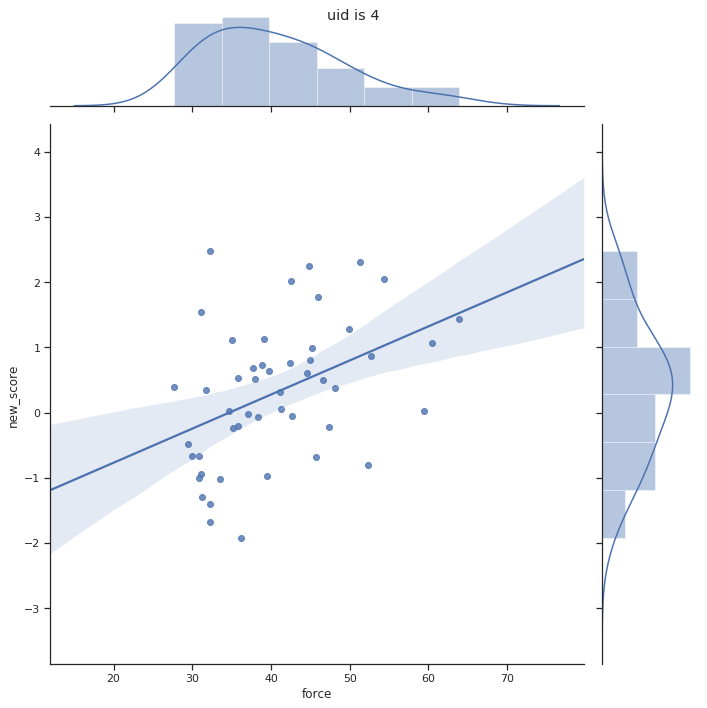

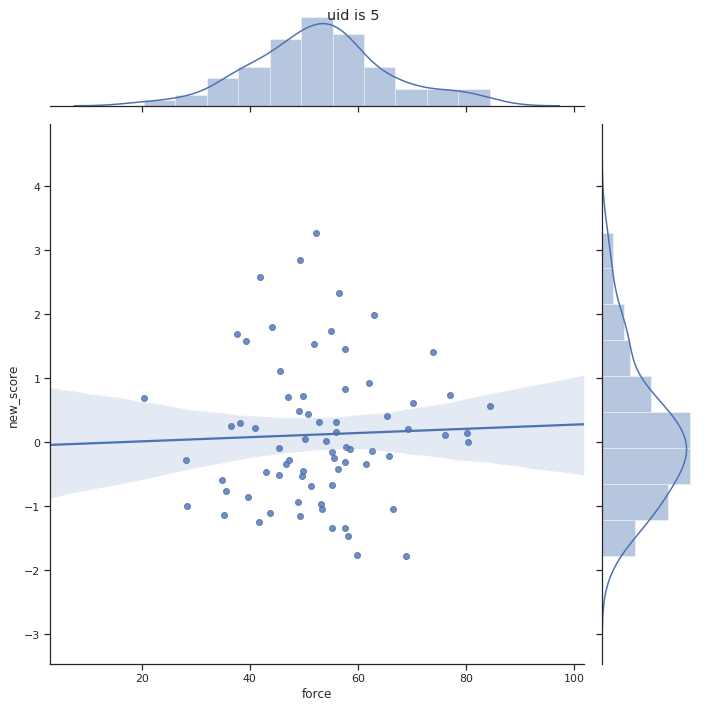

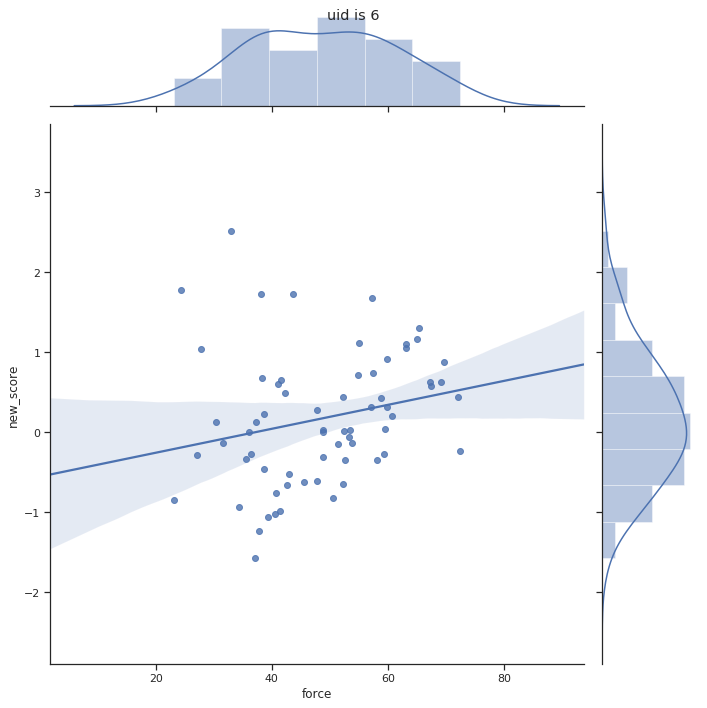

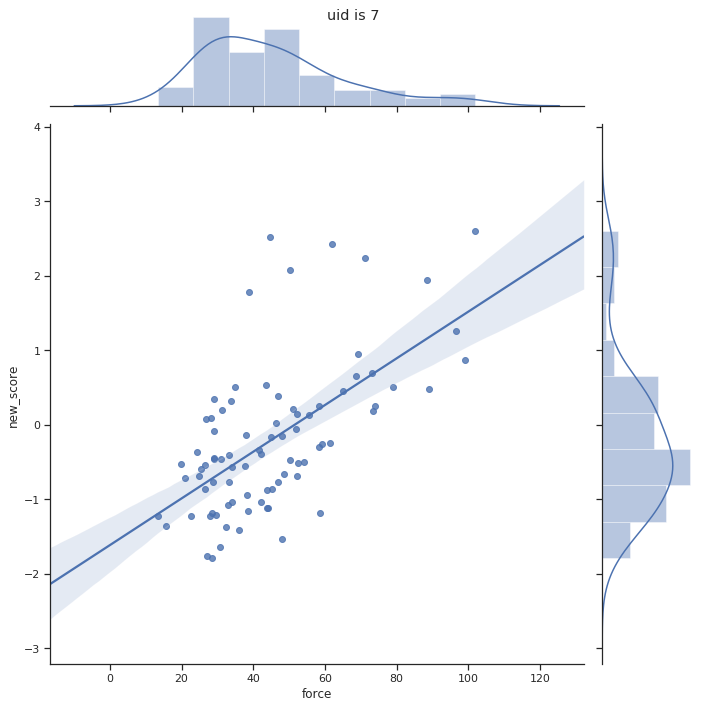

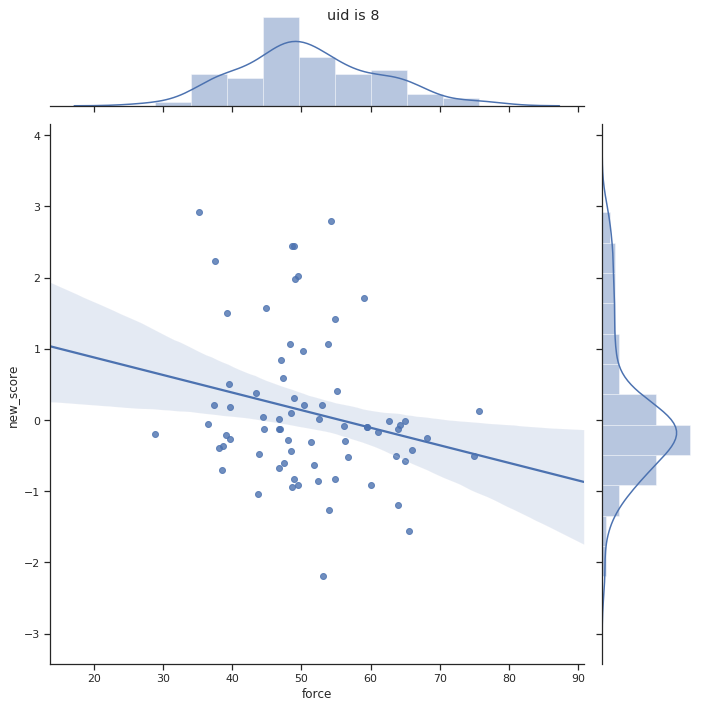

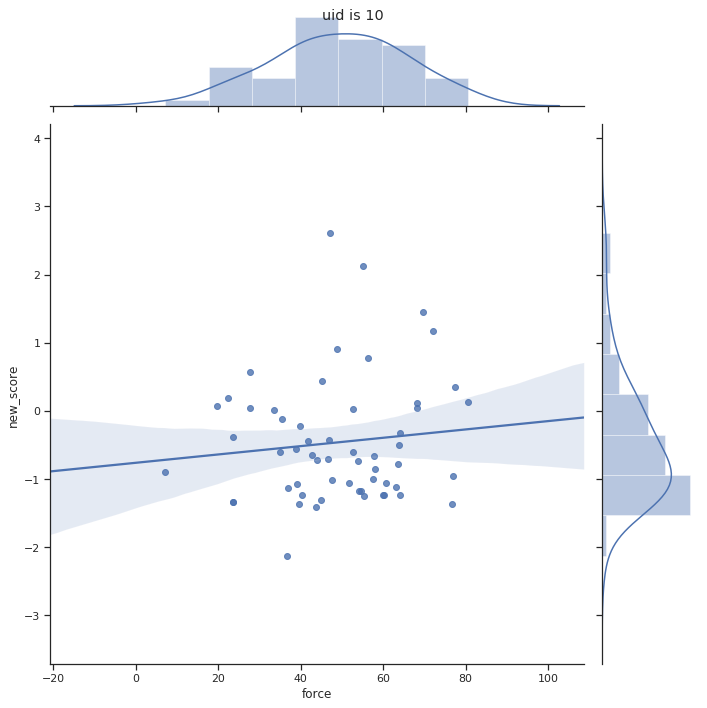

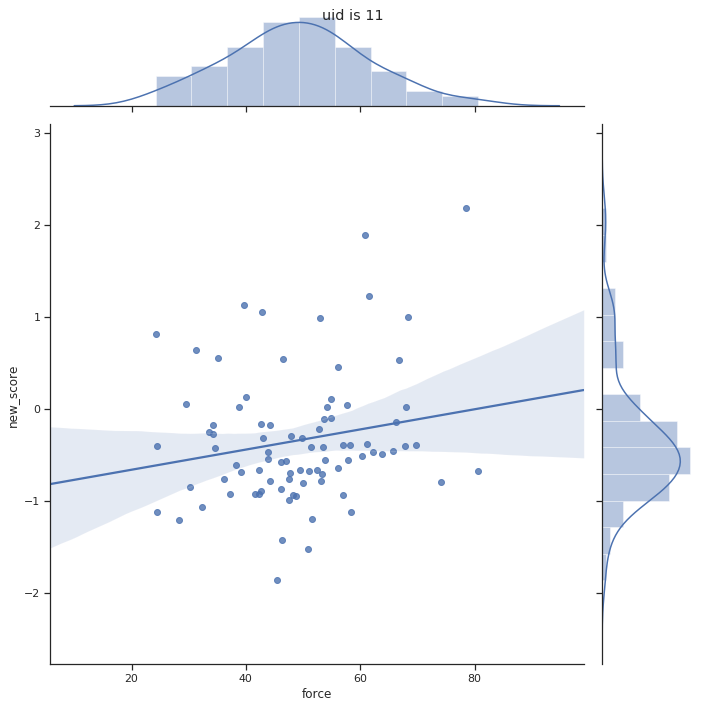

In [10]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="force", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))

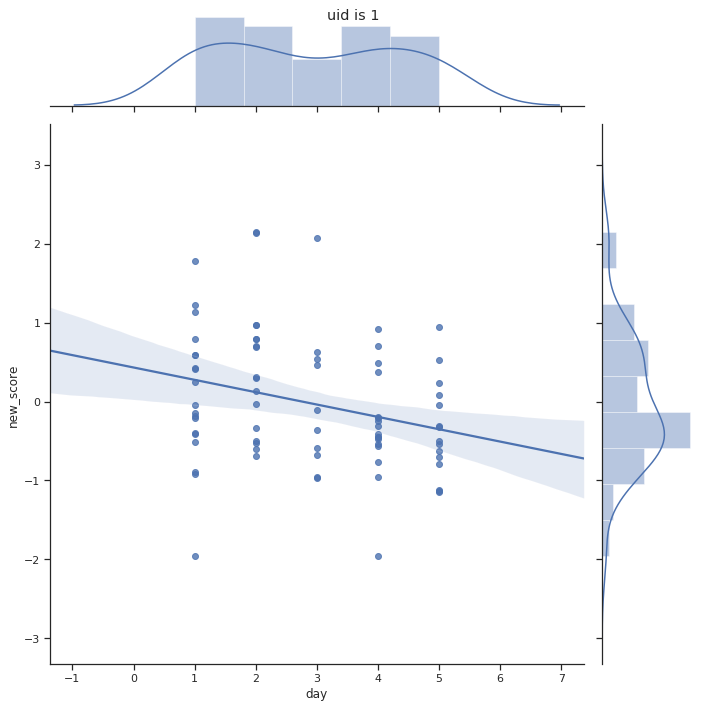

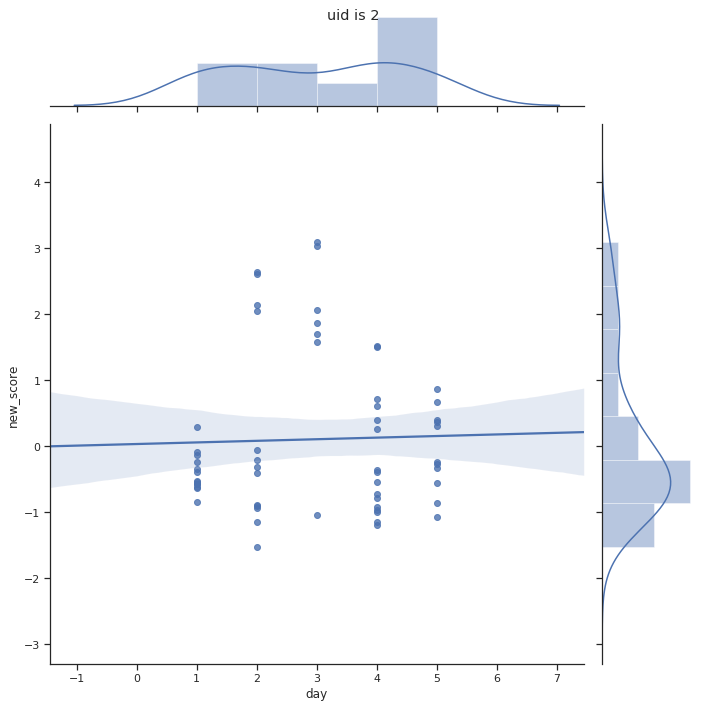

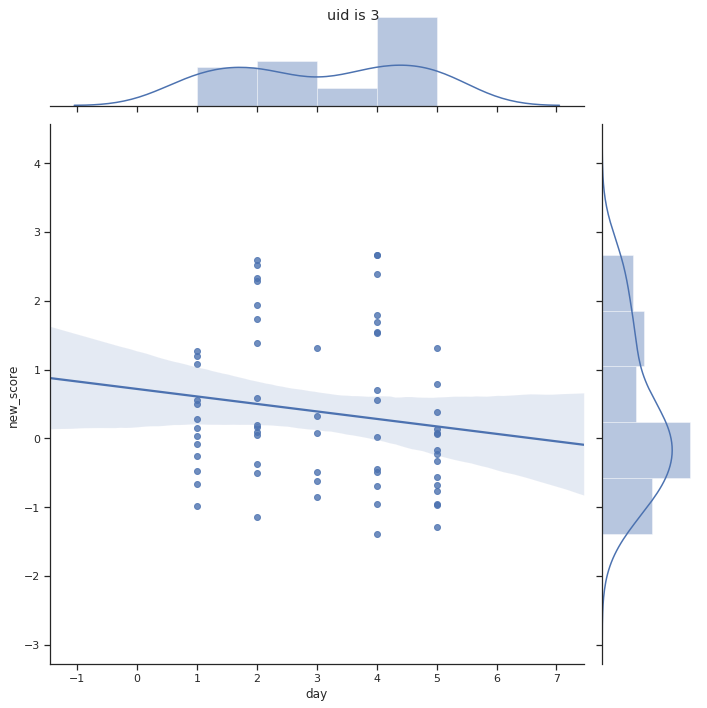

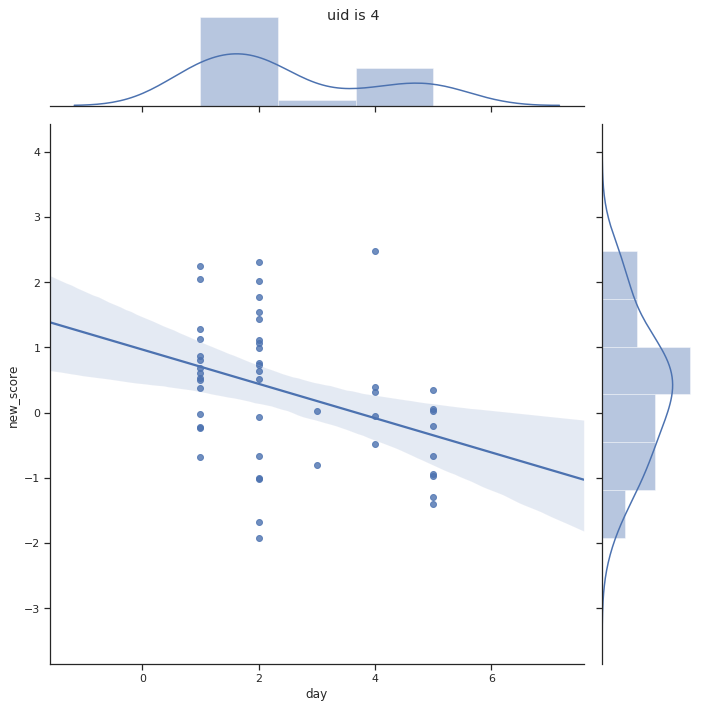

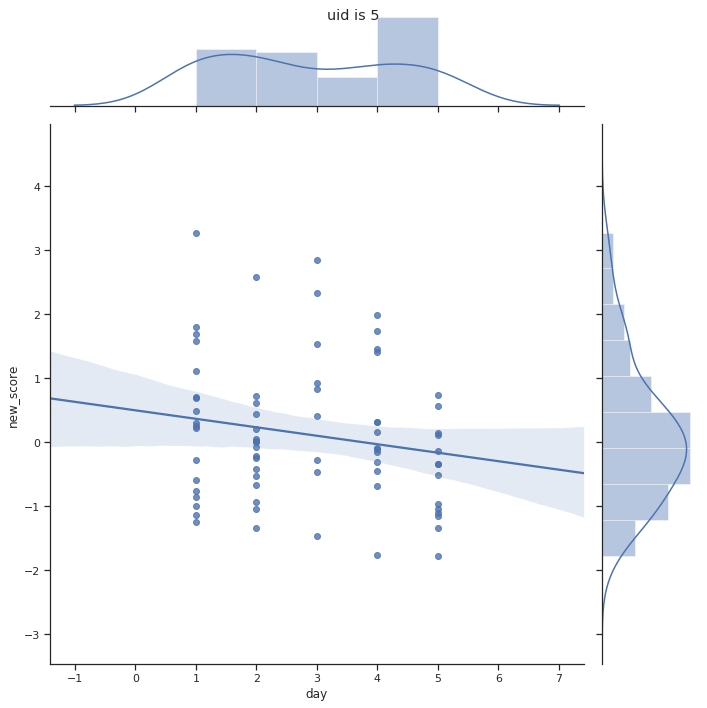

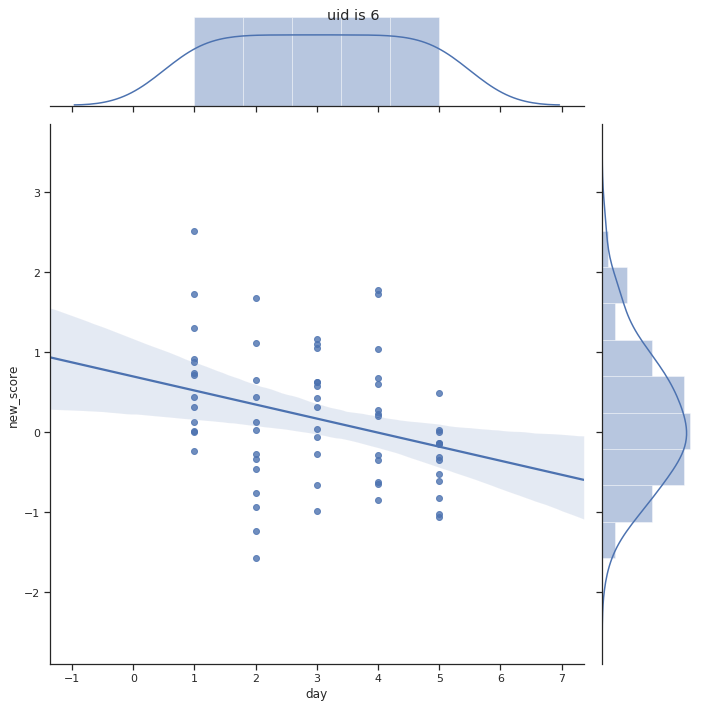

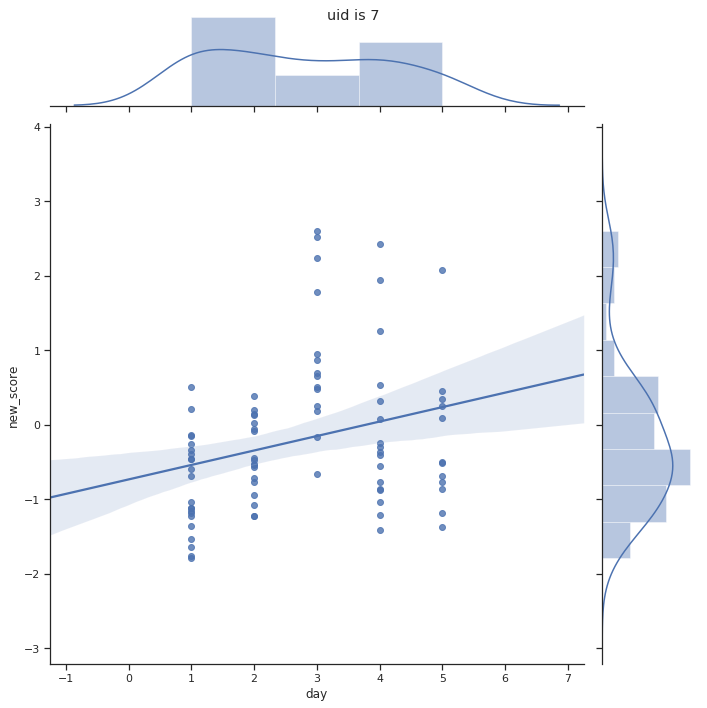

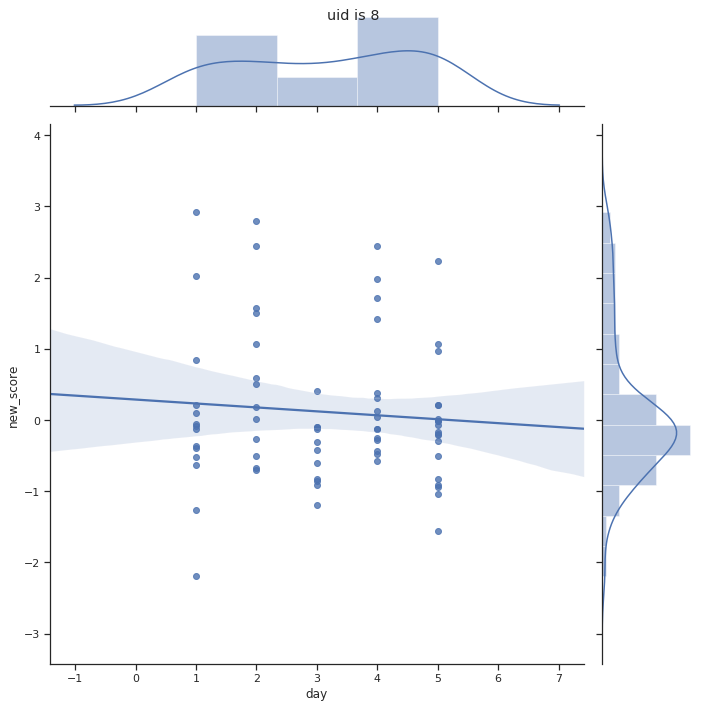

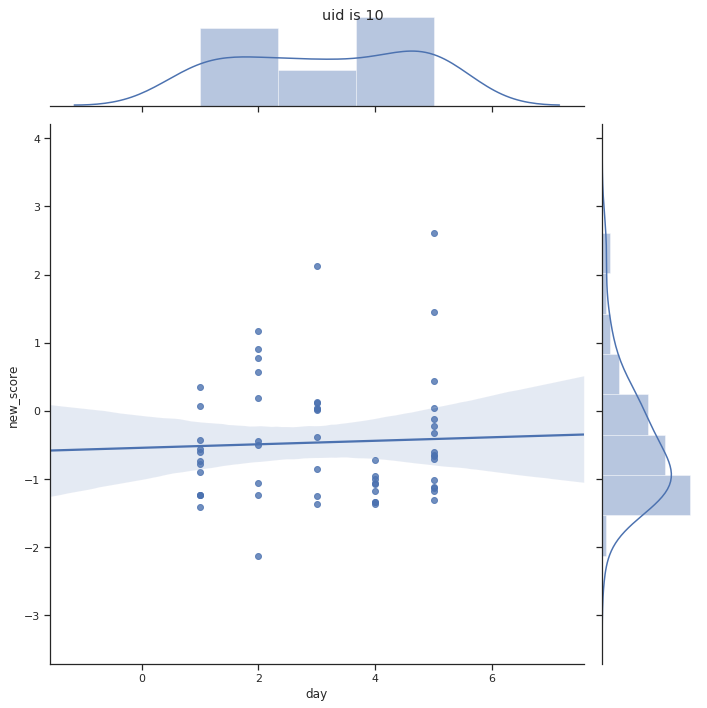

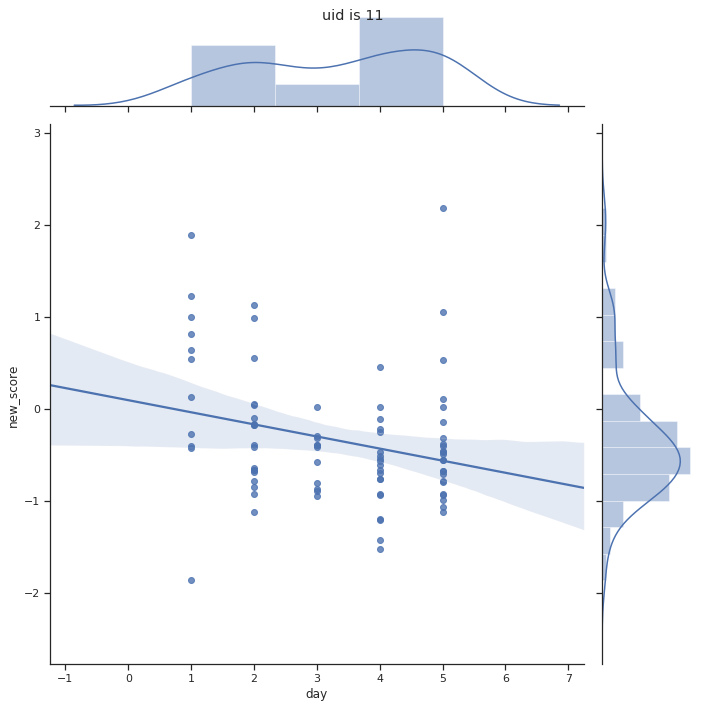

In [9]:
uids = [1,2,3,4,5,6,7,8,10,11]

for uid in uids:
    
    g = sns.JointGrid(x="day", y="new_score", data=tmp[tmp['uid']==uid], height=10)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.suptitle('uid is '+str(uid))